## Scratchpad

### For implementing model discussed in Geisler, 1984

See helper_fcns.py file for details

In [166]:
import numpy as np
import helper_fcns as hf
from scipy.stats import poisson
import autoreload
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import pandas as pd
import seaborn as sns
%matplotlib inline

#### Checking figure 1 - determining the linespread and pointspread functions

In [167]:
x = np.linspace(-4.25, 4.25, 101)
lsf = hf.linespread_function(x)

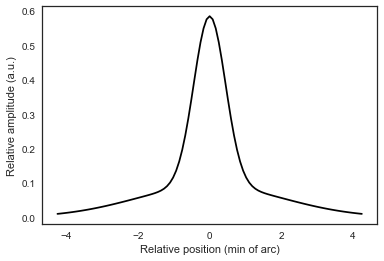

In [168]:
plt.plot(x, lsf, 'k')
#plt.ylim(0, 1.10)
plt.xlabel('Relative position (min of arc)')
_=plt.ylabel('Relative amplitude (a.u.)')

#### Point-spread function

Note: In the text, we assume the optics are isotropic, as in same everywhere. Thus, we can assume that the linespread function "generalizes" radially, and thus we use a 2D, radially symmetric gaussian to go from line-spread to point-spread

In [169]:
psf = hf.pointspread_function(x, x)

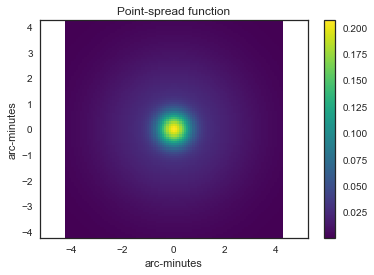

In [170]:
sns.set_style('white')
plt.imshow(psf, extent=[-4.25, 4.25, -4.25, 4.25], cmap='viridis');
plt.title('Point-spread function');
plt.xlabel('arc-minutes');
plt.ylabel('arc-minutes');
plt.axis('equal')
plt.colorbar();

#### Creating the hexagonal photoreceptor lattice

Since this is a hexagonal lattice, the center-to-center distances of any three neighboring cones form an equilateral triangle. We also know that this distance (equivalently, the diameter of the receptors) is .6 arcminutes.

Therefore (using some basic trigonometry: $\tan(\frac{\pi}{3})=\sqrt{3}$), if the center of one receptor is at the point $(0,0)$, then the neighboring receptors have centers at: $(.6, 0), (.3, .3\sqrt{3}), (-.3, .3\sqrt{3}), (-.6, 0), (-.3, -.3\sqrt{3}), (.3, -.3\sqrt{3})$

In [172]:
photoreceptors = hf.get_photoreceptor_locations(4.25, 4.25);

If we drew circles and the triangle on this, we could make this look like figure 2

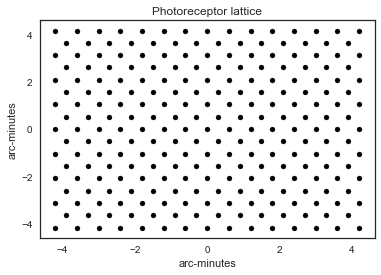

In [187]:
plotted = plt.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c='k', s=25)
plt.title('Photoreceptor lattice');
plt.xlabel('arc-minutes');
plt.ylabel('arc-minutes');

#### Calculating mean absorbtion

Determining the mean number of quanta absorbed is a simple linear calculation which is described in the Geisler paper (eq. 2).

In [174]:
# for creating luminance signal - just a point source
lum = 3; # in cd/m2
psf = hf.Pointspread_Function((0, 0));

col_labels = ['receptor area', 'stimulus duration', 'pupil area', 'ocular media transittance', 'photoreceptor efficiency', 'label', 'mean photons absorbed by center photoreceptor']
values = [[.28, .2, 3.1416, .68, .5, 'default'],
          [.28, .5, 3.1416, .68, .5, 'more time'],
          [.28, .2, 3.1416, .68, .9, 'more efficient'],
          [.2, .2, 3.1416, .68, .5, 'smaller receptors']]
df = []

for i, (a, d, s, t, e, label) in enumerate(values):
    photoreceptor_absorptions = hf.mean_photons_absorbed(psf, photoreceptors, lum, a, d, s, t, e)
    df.append(pd.DataFrame(dict((col, val) for val, col in zip([a, d, s, t, e, label, np.max(photoreceptor_absorptions)], col_labels)), index=[i]))
    # note: out of convenience, we know the stimulus is centered over the receptor lattice, so we can just take \
    # the max of the photoreceptor_absorptions array as the center
df = pd.concat(df)
df['percent default'] = 100 * df['mean photons absorbed by center photoreceptor'] / df[df.label=='default']['mean photons absorbed by center photoreceptor'].values

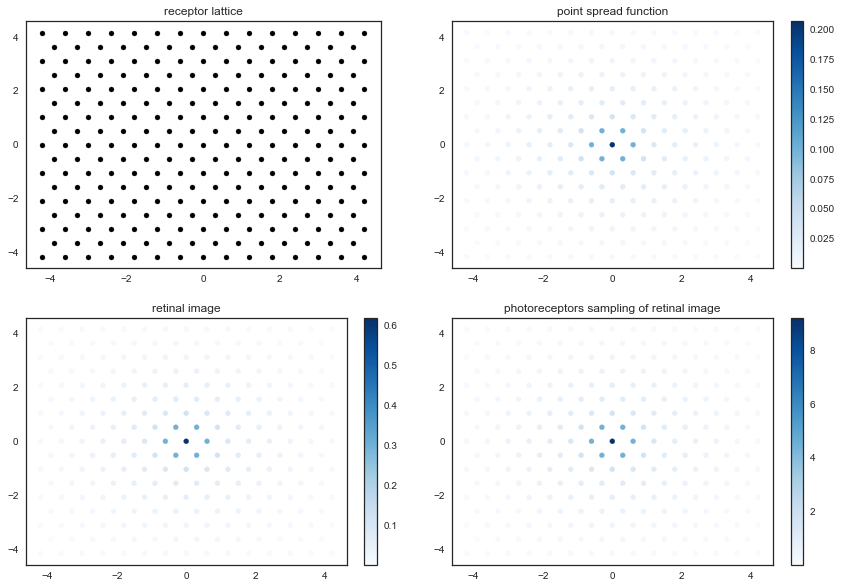

In [188]:
psf_eval = psf.pdf(photoreceptors[:, 0], photoreceptors[:, 1]);
data = [photoreceptors, psf_eval, lum*psf_eval, photoreceptor_absorptions]
titles = ['receptor lattice', 'point spread function', 'retinal image', 'photoreceptors sampling of retinal image']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, (im, title, ax) in enumerate(zip(data, titles, axes.flatten())):
    if i in [1, 2, 3]:
        plotted = ax.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c=im, cmap='Blues', s=25)
    elif i is 0:
        plotted = ax.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c='k', s=25)
    if i in [1,2,3]:
        plt.colorbar(plotted, ax=ax, fraction=.046)
    ax.set_title(title)

Note, the values in "retinal image" above are not necessarily correct. Some of the scalars that factor into "photoreceptors sampling of retinal image" are actually optical and would be contributing to the retinal image. 

The following aren't surprising: the mean absorbtion is linear in all parameters a, d, s, t, e 

In [189]:
df

,label,mean photons absorbed by center photoreceptor,ocular media transittance,photoreceptor efficiency,pupil area,receptor area,stimulus duration,percent default
0,default,12.897028,0.68,0.5,3.1416,0.28,0.2,100.000000
1,more time,32.242570,0.68,0.5,3.1416,0.28,0.5,250.000000
2,more efficient,23.214650,0.68,0.9,3.1416,0.28,0.2,180.000000
3,smaller receptors,9.212163,0.68,0.5,3.1416,0.20,0.2,71.428571


Now, we can compare distributions: how discriminable will these be?

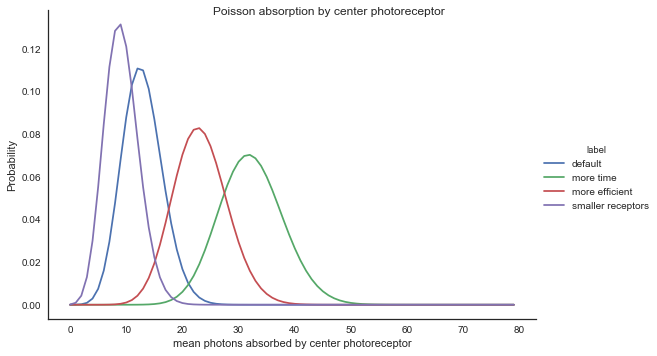

In [190]:
n_absorbed = np.arange(0, 80)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'mean photons absorbed by center photoreceptor')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend();

In the first plot (above), we show the distributions in mean number of photons absorbed. The second plot (below) shows the distributions as a percentage of the "default" distribution.

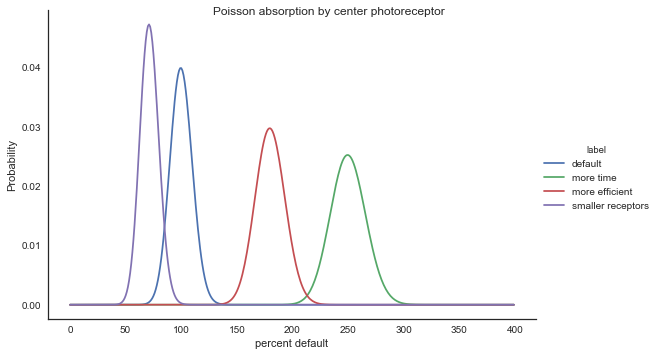

In [191]:
n_absorbed = np.arange(0, 400)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'percent default')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend();

### Intensity discrimination task
#### Generate figure 4

The numbers here don't line up. See the following graph. Nonetheless, our slope is correct.

Here, we're try to recreate Figure 4, finding the relationship between $N$ and $\Delta N$, where $N$ is the "mean number of quanta per stimulus", or $\sum_i\frac{\beta_i+\alpha_i}{2}$ and $\Delta N$ is the "average difference in number of effectively absorbed quanta from stimuli $\alpha$ and $\beta$ or $\sum_i\beta_i-\alpha_i$ when $d'=1.36$, at threshold. The line for our solution is consistently below Geisler's and it's not clear whether ours is correct.

I think it is, because our lies on the line given by $\Delta N=1.36\sqrt{N}$, which Geisler says is the correct solution. However, I'm not sure what the base of the logarithm used in the plot is. Presumably, it's the natural logarithm, which is shown below, but the position of our line (and the $\Delta N=1.36\sqrt{N}$ line) shifts around if a different base is used. But no reasonable value (2, 10, $e$) makes them line up, so I don't think that's the issue.

We'll first show a basic demonstration of the task; namely, two point sources incident on the same location with different intensities. Then, we can optimize for the correct luminance of the second source given the first source and the desired discriminability $d'$.

In [193]:
lum_a = 1;
lum_b = 1.2;
psf_intensity = hf.Pointspread_Function((0, 0))
d_prime, N, photoreceptors, abs_a, abs_b = hf.intensity_discr_task_gauss(lum_a, lum_b, psf=psf_intensity, debug=True);

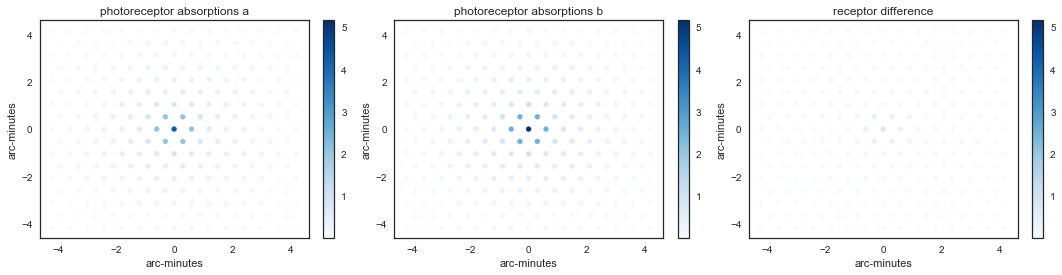

In [194]:
x_minutes = x_lattice.max()
y_minutes = y_lattice.max()
fig, axes = plt.subplots(1, 3, figsize=(18, 4), squeeze=True)
im_array = [abs_a, abs_b, abs_b-abs_a];
min_val = np.min(abs_b); max_val = np.max(abs_b); # b guaranteed to be larger
for ax, im, title in zip(axes.flatten(), im_array, ['photoreceptor absorptions a', 'photoreceptor absorptions b', 'receptor difference']):
    plotted = ax.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c=im, cmap='Blues', s=25, vmin=min_val, vmax=max_val)
    plt.colorbar(plotted, ax=ax, fraction=.04);
    ax.set_title(title);
    ax.set_xlabel('arc-minutes');
    ax.set_ylabel('arc-minutes');

/Users/paulgerald/work/classes/vision-models-winawer/geisler/Geisler1984/helper_fcns.py:306: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x), np.log10(y), 'k--', label='$\Delta N = 1.36\sqrt{N}$')


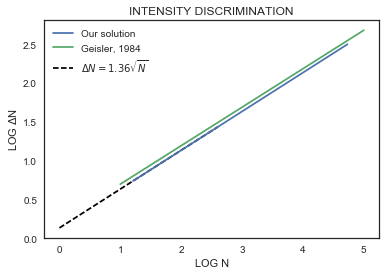

In [199]:
lum_a = [.2, .5, .75, 1, 2, 3, 4, 5, 6, 10, 15, 20, 50, 100, 800];
solts = hf.figure4(lum_a, d_prime=1.36);

#### Resolution task

We will again first start with a simple demonstration of the task. Here, one stimulus is a single point source while the second is comrpised of two point sources each of one-half the luminance of the first stimulus, and whose centers are separated by some distance $\Delta \theta$. For a given luminance and desire $d'$, we can optimize for the separation between point sources in the second stimulus. Then, we plot an optimized result, before finally generating the full figure.

As in the above task, we have some issues. In the range of larger luminance values, our slope matches that of Geisler, but has a constant offset. Additionally, for small luminance values, and therefore larger separations, our line does not hold constant slope. Instead, we overpredict the separation required to give the desired $d'$. These are likely two separate issues, and none of our investigations/fixes have worked.

In [200]:
delTheta = 3; # in arc-minutes
lum = 1; # a.u.
d_prime, photon_abs, photoreceptors, ret_abs_a, ret_abs_b = hf.resolution_task(delTheta, lum, debug=True)
print('The d-prime is %.2f' % (d_prime))

The d-prime is 5.38


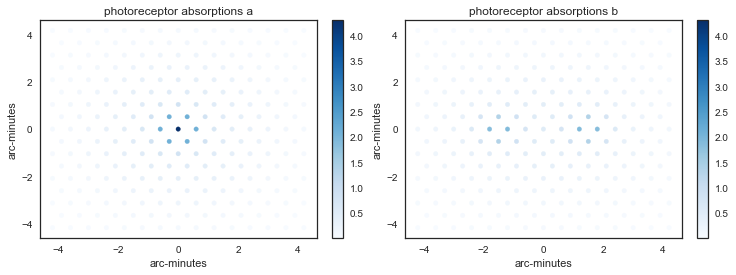

In [201]:
x_minutes = x_lattice.max()
y_minutes = y_lattice.max()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=True)
min_val = np.min(ret_abs_a); max_val = np.max(ret_abs_a); # 'a' guaranteed to be larger
for ax, im, title in zip(axes.flatten(), [ret_abs_a, ret_abs_b], ['photoreceptor absorptions a', 'photoreceptor absorptions b']):
    plotted = ax.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c=im, cmap='Blues', s=20, vmin=min_val, vmax=max_val)
    plt.colorbar(plotted, ax=ax, fraction=.04);
    ax.set_title(title);
    ax.set_xlabel('arc-minutes');
    ax.set_ylabel('arc-minutes');

In [202]:
task_lum = .1;
dTheta = hf.optimize_resolution_task(task_lum);
dprime, N, recs, abs_a, abs_b = hf.resolution_task(dTheta['x'], task_lum, debug=True)
print('For a luminance of %.3f, the separation required to give a d prime of %.2f is %.2f arc-minutes' \
      % (task_lum, dprime, dTheta['x']));

For a luminance of 0.100, the separation required to give a d prime of 1.36 is 2.20 arc-minutes


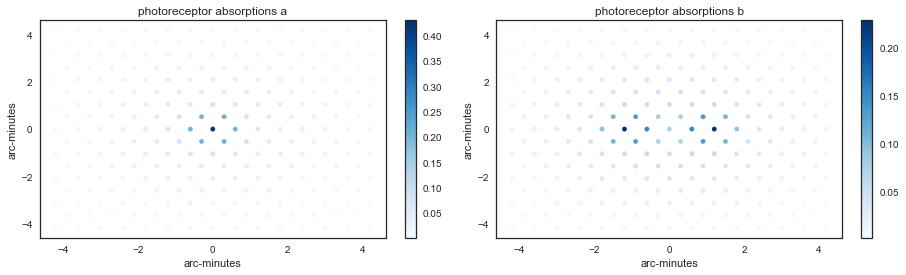

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), squeeze=True)
for ax, im, title in zip(axes.flatten(), [abs_a, abs_b], ['photoreceptor absorptions a', 'photoreceptor absorptions b']):
    plotted = ax.scatter(recs[:, 0], recs[:, 1], c=im, cmap='Blues', s=20)
    plt.colorbar(plotted, ax=ax, fraction=.04);
    ax.set_title(title);
    ax.set_xlabel('arc-minutes');
    ax.set_ylabel('arc-minutes');

In [214]:
autoreload.reload(hf);

Found solution for luminance 0.01: [ 11.1357104]
Found solution for luminance 0.05: [ 3.71656151]
Found solution for luminance 0.1: [ 2.20370605]
Found solution for luminance 0.5: [ 1.13166727]
Found solution for luminance 1: [ 0.91239448]
Found solution for luminance 5: [ 0.58021943]
Found solution for luminance 10: [ 0.48246452]
Found solution for luminance 15: [ 0.43382555]
Found solution for luminance 20: [ 0.40255031]
Found solution for luminance 50: [ 0.31795336]
Found solution for luminance 100: [ 0.26645239]
Found solution for luminance 130: [ 0.24928378]
Found solution for luminance 200: [ 0.22351953]
Found solution for luminance 300: [ 0.20175769]
Found solution for luminance 500: [ 0.17738]
Found solution for luminance 1000: [ 0.14899839]
Found solution for luminance 1500: [ 0.13457138]
Found solution for luminance 2500: [ 0.11838154]


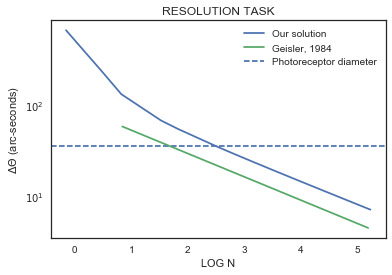

In [215]:
lum=[.01, .05, .1, .5, 1, 5, 10, 15, 20, 50, 100, 130, 200, 300, 500, 1000, 1500, 2500]
# lum = [.1, .5, 1, 5, 10, 15, 20, 50, 100, 130, 200, 300, 500, 1000, 1500, 2500]
solts = hf.figure5(lum)

### Summary

We have attempted to reproduce the main model in the Geisler (1984) paper. We have implemented two of the four tasks, namely intensity discrimination and (spatial) resolution. In the former task, we have the same slope as Geisler but our line is offset by some constant. In the latter task, we have a similar offset issue in addition to a breaking of the slope at low luminance values.

We have tried a few fixes for both issues, none of which have worked. We offset the stimuli relative to the photoreceptor lattice to see if relative position of the stimulus and the receptors was important. As in the Geisler paper, this does not change the results, meaning that we did not fix the line offset. We have also investigated overall photoreceptor lattice size; as long as the lattice is big enough to contain the bulk of the stimuli's gaussian, further increases in lattice size do not affect the results. We have checked for any boundary/edge issues, such as zeros in the photoreceptor absorbtion for one stimulus but not the other; no such issues exist, to the best of our knowledge. Furthermore, our current implementation relies on evaluating gaussian functions at arbitrary values, which eliminates a previous problem with resolution in the photoreceptor lattice.

As far as potential issues that still exist with the code (and cause our figures to be different than Geisler's), we suspsect that we have made some assumption in a different way than Geisler. His paper is sparse on specific implementation details, and we may have incorrectly implemented certain steps or calculations. This would only solve the offset issue. As for the failure of the optimization/model at low luminance values in the resolution task, we do not have many intuitions.

#### Assumptions and limitations

The following are assumptions that Geisler does not state, but that we made in order to complete our calculations:

- Our creation of the receptor lattice was done based solely on figure 2 and the accompanying text which specify the receptor diameter (0.6 arcminutes) and the row/column offsets. Despite this, we don't know if he implemented a fixed receptor lattice, or - like us - Gaussians which can be arbitrarily sampled, or something else entirely! This shouldn't matter for intensity discrimination but will matter for any task in which two stimuli do not share the same exact spatial profie.
- Formulas for $\Delta N$ and $N$: We determined these values by setting the log ratios in equation 3 (for $d'$) to 1, and assuming the numerator gives $\Delta N$ and the denominator gives $\sqrt{N}$
- We assume a single-interval, rather than two-interval, forced choice paradigm. The difference in $d'$ between the two tasks is some constant scaling
  - We did try this briefly and it did not fix our scaling issue
- Geisler does not state what base the log-log plots are in; we assume log base 10, but also tried other bases ($e$, 2)
- In order to complete the optimization of these tasks, we went from an (arbitrary) image-computable model to one which assumes the input image is either one or two point sources